In [14]:
# imports
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

#### Loading the images from the data folder 

In [15]:
def load_dataset_with_names(folder_path):
    dataset = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if file_path.endswith(('.png')):
            img = Image.open(file_path)

            img_array = np.array(img)

            parts = filename.split('.')
            subject = parts[0]
            emotion = parts[1]

            img_info = {'image': img_array, 'subject': subject, 'emotion': emotion}

            dataset.append(img_info)

    return dataset


In [16]:
folder_path = 'data/'
image_dataset_raw = load_dataset_with_names(folder_path)

In [7]:
image_dataset_raw[0]

{'image': array([[130, 130, 130, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8),
 'subject': 'subject01',
 'emotion': 'centerlight'}

In [13]:
print(f"Number of images: {len(image_dataset_raw)}")
print(f"shape of Images: {image_dataset_raw[0]['image'].shape}")

Number of images: 165
shape of Images: (243, 320)


#### Preparing the training dataset
* we made use of the subjects' "normal" images i.e. normal facial expression

In [17]:
train_data = [image_dataset_raw[i]['image'] for i in range(0, len(image_dataset_raw)) if image_dataset_raw[i]['emotion'] == 'normal']

In [21]:
print(len(train_data))
print(train_data[0].shape) 


15
(243, 320)


In [35]:
# Image displayer function
def display_images(image_arrays):
    num_images = len(image_arrays)
    num_rows = 3
    num_cols = 5
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(image_arrays[i], cmap='gray')
            ax.set_title(f"Image {i+1}")
        else:
            ax.axis('off')

    plt.show()

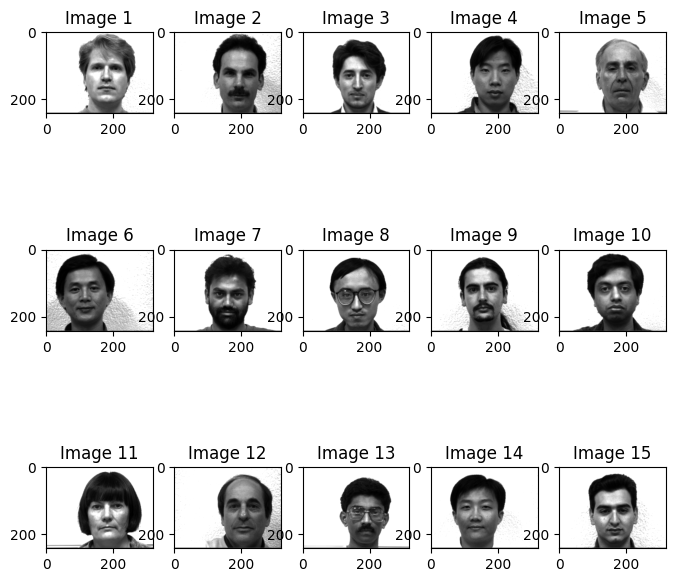

In [36]:
display_images(train_data)